ASCAT Coastal Winds 12.5km product: https://data.eumetsat.int/product/EO:EUM:DAT:METOP:OSI-104  
Validation analysis: https://scatterometer.knmi.nl/publications/pdf/ascat_validation.pdf  
eumdac guide here: https://user.eumetsat.int/resources/user-guides/eumetsat-data-access-client-eumdac-guide  
environment requires eumdac installed, available through conda, and a EUMETSAT account

In [4]:
import subprocess, os
# os.chdir('/datasets/work/oa-acs-wp3/work/observational_data/ascat/download')
# subprocess.run(['eumdac', 'download', '--collection', 'EO:EUM:DAT:METOP:OSI-104', '--start', '2016-01-01T00:00:00.000', '--end', '2017-01-01T00:00:00.000', '--bbox', '109.8', '-46.87', '155.24', '-9.66'])

In [3]:
input_folder = '/datasets/work/oa-acs-wp3/work/observational_data/ascat'
output_folder = os.path.join(input_folder, 'unzip')

zip_list = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.l2.zip')]

# for i, f in enumerate(zip_list):
#     subprocess.run(['unzip', f, '-x', 'EOPMetadata.xml', 'manifest.xml', '-d', output_folder])

Archive:  /datasets/work/oa-acs-wp3/work/observational_data/ascat/ascat_20151231_224800_metopa_47739_eps_o_coa_2300_ovw.l2.zip
  inflating: /datasets/work/oa-acs-wp3/work/observational_data/ascat/unzip/ascat_20151231_224800_metopa_47739_eps_o_coa_2300_ovw.l2.nc  
Archive:  /datasets/work/oa-acs-wp3/work/observational_data/ascat/ascat_20151231_234200_metopb_17053_eps_o_coa_2201_ovw.l2.zip
  inflating: /datasets/work/oa-acs-wp3/work/observational_data/ascat/unzip/ascat_20151231_234200_metopb_17053_eps_o_coa_2201_ovw.l2.nc  
Archive:  /datasets/work/oa-acs-wp3/work/observational_data/ascat/ascat_20160101_003000_metopa_47740_eps_o_coa_2300_ovw.l2.zip
  inflating: /datasets/work/oa-acs-wp3/work/observational_data/ascat/unzip/ascat_20160101_003000_metopa_47740_eps_o_coa_2300_ovw.l2.nc  
Archive:  /datasets/work/oa-acs-wp3/work/observational_data/ascat/ascat_20160101_012400_metopb_17054_eps_o_coa_2201_ovw.l2.zip
  inflating: /datasets/work/oa-acs-wp3/work/observational_data/ascat/unzip/ascat_

for creation of .feather format tables for later ingestion of ascat data, see collate_ascat_data.py

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatch
from shapely import Point, Polygon
import geopandas as gpd
import cartopy

In [2]:
open_bndy = pd.read_csv('/datasets/work/oa-acs-wp3/work/SCHISM_FINAL/open_bnd/bnd_mesh/bndy_all_20231120.csv')
input_folder = '/datasets/work/oa-acs-wp3/work/observational_data/ascat'
output_folder = os.path.join(input_folder, 'unzip')
fname = [os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith('.nc')][0]
print(fname)
a = xr.open_dataset(fname, chunks='auto')
a

/datasets/work/oa-acs-wp3/work/observational_data/ascat/unzip/ascat_20151231_224800_metopa_47739_eps_o_coa_2300_ovw.l2.nc


<xarray.Dataset>
Dimensions:           (NUMROWS: 3264, NUMCELLS: 82)
Coordinates:
    lat               (NUMROWS, NUMCELLS) float64 dask.array<chunksize=(3264, 82), meta=np.ndarray>
    lon               (NUMROWS, NUMCELLS) float64 dask.array<chunksize=(3264, 82), meta=np.ndarray>
Dimensions without coordinates: NUMROWS, NUMCELLS
Data variables:
    time              (NUMROWS, NUMCELLS) datetime64[ns] dask.array<chunksize=(3264, 82), meta=np.ndarray>
    wvc_index         (NUMROWS, NUMCELLS) float32 dask.array<chunksize=(3264, 82), meta=np.ndarray>
    model_speed       (NUMROWS, NUMCELLS) float32 dask.array<chunksize=(3264, 82), meta=np.ndarray>
    model_dir         (NUMROWS, NUMCELLS) float32 dask.array<chunksize=(3264, 82), meta=np.ndarray>
    ice_prob          (NUMROWS, NUMCELLS) float32 dask.array<chunksize=(3264, 82), meta=np.ndarray>
    ice_age           (NUMROWS, NUMCELLS) float32 dask.array<chunksize=(3264, 82), meta=np.ndarray>
    wvc_quality_flag  (NUMROWS, NUMCELLS) float64 dask.array<chunksize=(3264, 82), meta=np.ndarray>
    wind_speed        (NUMROWS, NUMCELLS) float32 dask.array<chunksize=(3264, 82), meta=np.ndarray>
    wind_dir          (NUMROWS, NUMCELLS) float32 dask.array<chunksize=(3264, 82), meta=np.ndarray>
    bs_distance       (NUMROWS, NUMCELLS) float32 dask.array<chunksize=(3264, 82), meta=np.ndarray>
Attributes: (12/29)
    title:                            MetOp-A ASCAT Level 2 Coastal Ocean Sur...
    title_short_name:                 ASCATA-L2-Coastal
    Conventions:                      CF-1.4
    institution:                      EUMETSAT/OSI SAF/KNMI
    source:                           MetOp-A ASCAT
    software_identification_level_1:  903
    ...                               ...
    orbit_inclination:                98.7
    history:                          N/A
    references:                       ASCAT Wind Product User Manual, http://...
    comment:                          Orbit period and inclination are consta...
    creation_date:                    2016-01-01
    creation_time:                    01:40:33

In [119]:
acs_mpl = mpath.Path([(lon, lat) for lon, lat in open_bndy.values])
area_mask = ~acs_mpl.contains_points(np.stack((a.lon.values.ravel(), a.lat.values.ravel()), axis=1)).reshape(-1, a.NUMCELLS.shape[0])

In [15]:
def create_ascat_mask(bitmask, check=(11, 12, 13, 14, 16, 17, 18, 20, 21, 22)):
    """
    Masked values as follows:
    2048	small_wind_less_than_or_equal_to_3_m_s
    4096	large_wind_greater_than_30_m_s
    8192	wind_inversion_not_successful
    16384	some_portion_of_wvc_is_over_ice
    65536	variational_quality_control_fails
    131072	knmi_quality_control_fails
    262144	product_monitoring_event_flag
    1048576	any_beam_noise_content_above_threshold
    2097152	poor_azimuth_diversity
    4194304	not_enough_good_sigma0_for_wind_retrieval
    """
    if isinstance(bitmask, np.ndarray) and bitmask.dtype =='float64':
        bitmask = bitmask.astype(int)
    checkmask = sum(2**x for x in check)
    return (bitmask & checkmask) > 0

In [99]:
data_mask = create_ascat_mask(a.wvc_quality_flag.values)

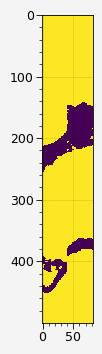

In [103]:
plt.imshow(mask[1500:2000] + area_mask[1500:2000], interpolation='none')

In [80]:
aus_albers = cartopy.crs.AlbersEqualArea(
    central_longitude=132,
    standard_parallels=[-18, -36],
    globe=cartopy.crs.Globe(ellipse='GRS80')
)

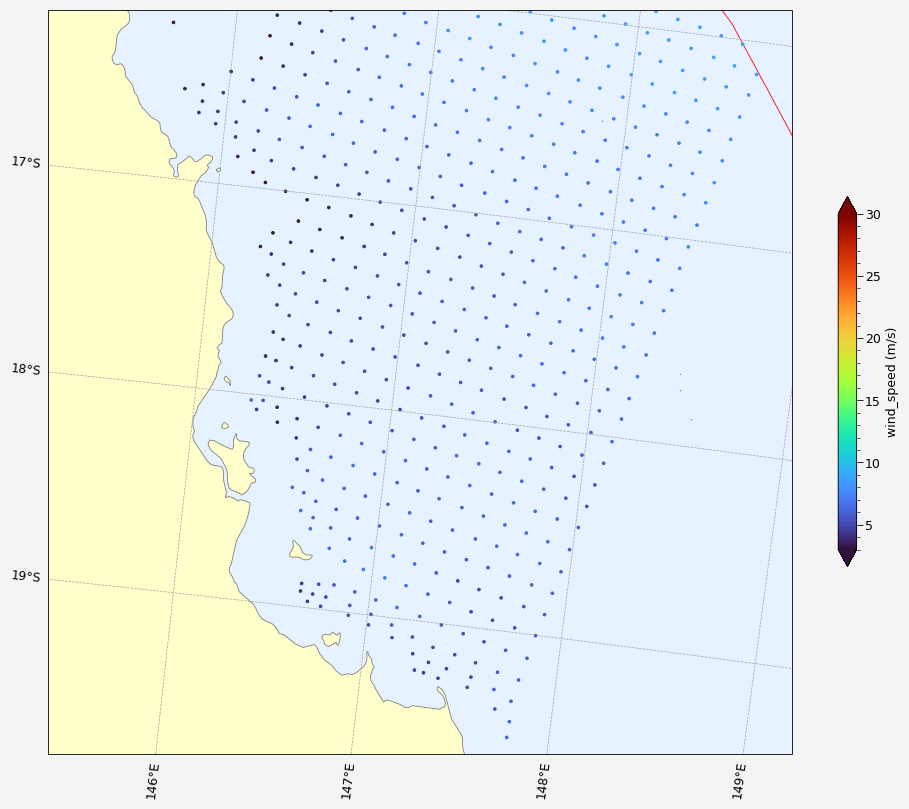

In [138]:
f, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection=aus_albers))
ax.set_facecolor('#e6f2ff')

ax.add_patch(mpatch.PathPatch(acs_mpl, fc='none', ec='r', transform=cartopy.crs.PlateCarree()))
im = ax.scatter(a.lon, a.lat, c=np.ma.array(a.wind_speed, mask=data_mask + area_mask), cmap='turbo', vmin=3, vmax=30, s=4, transform=cartopy.crs.PlateCarree())
ax.set_extent((1400000, 1800000, -2200000, -1800000), crs=aus_albers)
ax.gridlines(lw=0.5, ls='--', color='#a0a0a0', draw_labels=['left', 'bottom'])
land_feature = cartopy.feature.NaturalEarthFeature(category='physical', name='land', scale='10m',
                                                   facecolor='#ffffcc', edgecolor='#808080')
ax.add_feature(land_feature)
f.colorbar(im, ax=ax, shrink=0.4, label='wind_speed (m/s)', extend='both')

In [62]:
df_list = []
for fn in os.listdir('/datasets/work/oa-acs-wp3/work/observational_data/ascat/feather'):
    df = pd.read_feather(os.path.join('/datasets/work/oa-acs-wp3/work/observational_data/ascat/feather', fn))
    print(df.shape)
    area_mask = ~acs_mpl.contains_points(df[['lon', 'lat']].values)
    data_mask = create_ascat_mask(df.wvc_quality_flag.values)
    mask = area_mask# + data_mask
    df_list.append(df[~mask])
scat_df = pd.concat(df_list, ignore_index=True)

(76762933, 6)
(76626339, 6)
(76341296, 6)
(76312063, 6)
(76343993, 6)
(75876763, 6)
(75996798, 6)
(75512807, 6)
(55155583, 6)


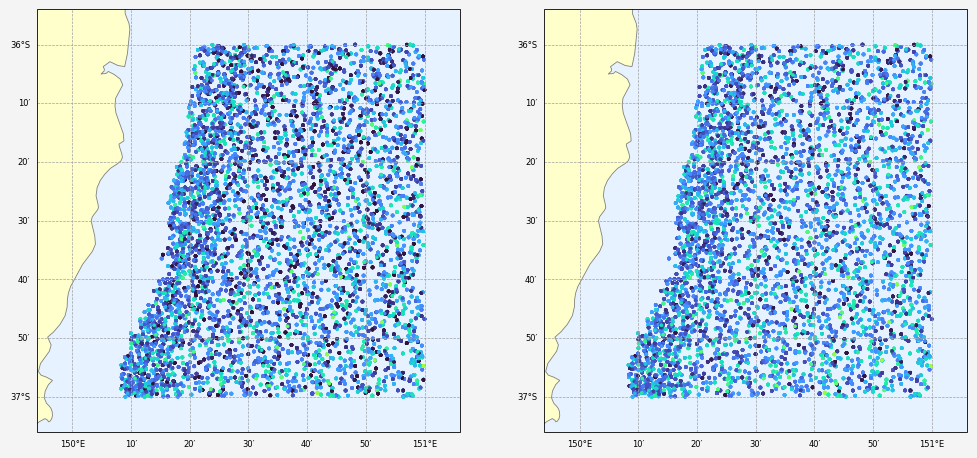

In [52]:
sub_df = scat_df[np.logical_and.reduce((scat_df.lon >=150, scat_df.lon < 151, scat_df.lat >= -37, scat_df.lat < -36))]
mask_df = sub_df[~create_ascat_mask(sub_df.wvc_quality_flag)]
f, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
axes[0].scatter(sub_df.lon, sub_df.lat, c=sub_df.wind_speed, vmin=3, vmax=30, cmap='turbo', transform=cartopy.crs.PlateCarree(), s=4)
axes[1].scatter(mask_df.lon, mask_df.lat, c=mask_df.wind_speed, vmin=3, vmax=30, cmap='turbo', transform=cartopy.crs.PlateCarree(), s=4)
for ax in axes:
    ax.set_facecolor('#e6f2ff')
    ax.add_feature(cartopy.feature.NaturalEarthFeature(category='physical', name='land', scale='10m',
                                                   facecolor='#ffffcc', edgecolor='#808080'))
    ax.set_extent((149.9, 151.1, -37.1, -35.9))
    ax.gridlines(lw=0.5, ls='--', color='#a0a0a0', draw_labels=['left', 'bottom'],
                 xlocs=np.arange(7) / 6 + 150, ylocs=np.arange(7) / 6 - 37, dms=True,
                 xlabel_style=dict(fontsize=6), ylabel_style=dict(fontsize=6))

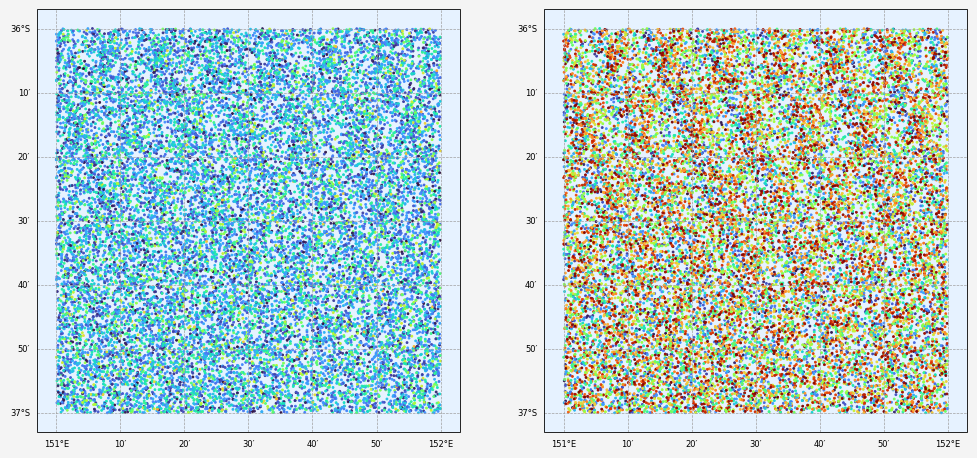

In [68]:
sub_df = scat_df[np.logical_and.reduce((scat_df.lon >=151, scat_df.lon < 152, scat_df.lat >= -37, scat_df.lat < -36))]
mask_df = sub_df[~create_ascat_mask(sub_df.wvc_quality_flag)]
mask_df = mask_df[mask_df.sat == 'metopb']
f, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
axes[0].scatter(mask_df.lon, mask_df.lat, c=mask_df.wind_speed, vmin=3, vmax=30, cmap='turbo', transform=cartopy.crs.PlateCarree(), s=2)
axes[1].scatter(mask_df.lon, mask_df.lat, c=mask_df.time, cmap='turbo', transform=cartopy.crs.PlateCarree(), s=2)
for ax in axes:
    ax.set_facecolor('#e6f2ff')
    ax.add_feature(cartopy.feature.NaturalEarthFeature(category='physical', name='land', scale='10m',
                                                   facecolor='#ffffcc', edgecolor='#808080'))
    ax.set_extent((150.95, 152.05, -37.05, -35.95))
    ax.gridlines(lw=0.5, ls='--', color='#a0a0a0', draw_labels=['left', 'bottom'], 
                 xlocs=np.arange(7) / 6 + 151, ylocs=np.arange(7) / 6 - 37, dms=True,
                 xlabel_style=dict(fontsize=6), ylabel_style=dict(fontsize=6))

In [74]:
pd.Series(create_ascat_mask(sub_df.wvc_quality_flag)).value_counts()

wvc_quality_flag
False    40420
True      3045
Name: count, dtype: int64

In [125]:
s = scat_df[~create_ascat_mask(scat_df.wvc_quality_flag)]
s

,time,lon,lat,wind_speed,wvc_quality_flag,sat,x,y,xcut,ycut
0,2015-12-31 23:39:20,139.93826,-8.36526,6.75,32768,metopa,905307.947585,-9.011842e+05,900000.0,-925000.0
1,2015-12-31 23:39:20,139.83578,-8.32518,7.03,32768,metopa,893897.732913,-8.961927e+05,875000.0,-900000.0
2,2015-12-31 23:39:20,139.74829,-8.29587,7.26,32768,metopa,884118.862127,-8.924618e+05,875000.0,-900000.0
3,2015-12-31 23:39:20,139.65584,-8.27892,7.62,32768,metopa,873690.879608,-8.900204e+05,850000.0,-900000.0
4,2015-12-31 23:39:20,139.56990,-8.26964,8.22,32768,metopa,863953.516603,-8.884476e+05,850000.0,-900000.0
...,...,...,...,...,...,...,...,...,...,...
14373071,2017-01-01 00:16:03,140.91145,-39.52375,6.81,0,metopa,775744.905765,-4.349017e+06,775000.0,-4350000.0
14373072,2017-01-01 00:16:05,141.46698,-39.69808,7.03,0,metopa,822604.341239,-4.371538e+06,800000.0,-4375000.0
14373073,2017-01-01 00:16:05,141.32323,-39.68415,7.12,0,metopa,810247.188840,-4.369098e+06,800000.0,-4375000.0
14373074,2017-01-01 00:16:05,141.18408,-39.66841,7.19,0,metopa,798298.976217,-4.366503e+06,775000.0,-4375000.0


In [79]:
s.sat.value_counts()

sat
metopb    6241858
metopa    6207281
Name: count, dtype: int64

In [81]:
xyz = aus_albers.transform_points(cartopy.crs.PlateCarree(), scat_df.lon, scat_df.lat)
scat_df['x'] = xyz[:, 0]
scat_df['y'] = xyz[:, 1]
cell_size = 25000
cuts = {}
for dim in ['x', 'y']:
    cuts[dim] = np.arange(np.floor(scat_df[dim].min() / cell_size) * cell_size, np.ceil(scat_df[dim].max() / cell_size) * cell_size, cell_size)
    scat_df[f'{dim}cut'] = pd.cut(scat_df[dim], cuts[dim], labels=cuts[dim][:-1])

In [124]:
scat_df.head()

,time,lon,lat,wind_speed,wvc_quality_flag,sat,x,y,xcut,ycut
0,2015-12-31 23:39:20,139.93826,-8.36526,6.75,32768,metopa,905307.947585,-901184.159027,900000.0,-925000.0
1,2015-12-31 23:39:20,139.83578,-8.32518,7.03,32768,metopa,893897.732913,-896192.711607,875000.0,-900000.0
2,2015-12-31 23:39:20,139.74829,-8.29587,7.26,32768,metopa,884118.862127,-892461.809558,875000.0,-900000.0
3,2015-12-31 23:39:20,139.65584,-8.27892,7.62,32768,metopa,873690.879608,-890020.410847,850000.0,-900000.0
4,2015-12-31 23:39:20,139.56990,-8.26964,8.22,32768,metopa,863953.516603,-888447.550837,850000.0,-900000.0


In [126]:
density = s.groupby(['xcut', 'ycut'])['x'].count().values.reshape(cuts['x'].shape[0] - 1, -1).T

/tmp/ipykernel_937229/1381038491.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  density = s.groupby(['xcut', 'ycut'])['x'].count().values.reshape(cuts['x'].shape[0] - 1, -1).T


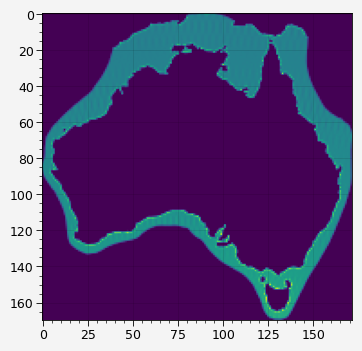

In [102]:
plt.imshow(density)

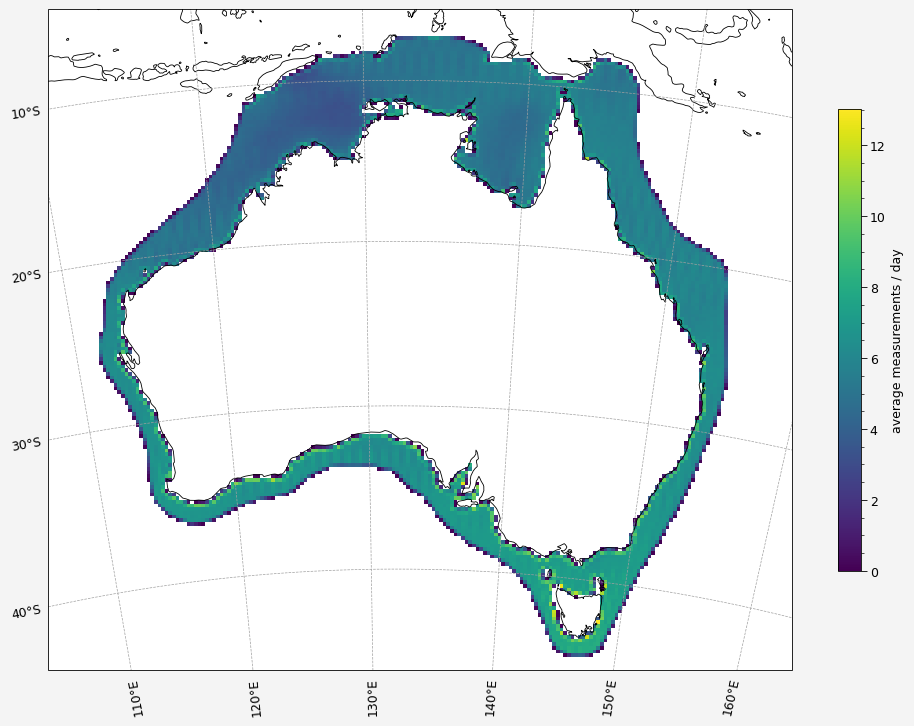

In [127]:
f, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection=aus_albers))
im = ax.imshow(np.ma.array(density, mask=density==0) / 366, origin='lower', cmap='viridis', extent=(cuts['x'][0], cuts['x'][-2], cuts['y'][0], cuts['y'][-2]), 
          interpolation='none', transform=aus_albers, vmin=0)
f.colorbar(im, ax=ax, shrink=0.5, label='average measurements / day')
ax.coastlines()
ax.set_extent((acs_shply.bounds[0], acs_shply.bounds[2], acs_shply.bounds[1], acs_shply.bounds[3] + 2))
ax.gridlines(lw=0.5, ls='--', color='#a0a0a0', draw_labels=['left', 'bottom'], ylocs=np.arange(-80, 0, 10))

In [128]:
s.to_feather('/datasets/work/oa-acs-wp3/work/observational_data/ascat/feather/ascat_2016_screened.fth')

In [129]:
s.head()

,time,lon,lat,wind_speed,wvc_quality_flag,sat,x,y,xcut,ycut
0,2015-12-31 23:39:20,139.93826,-8.36526,6.75,32768,metopa,905307.947585,-901184.159027,900000.0,-925000.0
1,2015-12-31 23:39:20,139.83578,-8.32518,7.03,32768,metopa,893897.732913,-896192.711607,875000.0,-900000.0
2,2015-12-31 23:39:20,139.74829,-8.29587,7.26,32768,metopa,884118.862127,-892461.809558,875000.0,-900000.0
3,2015-12-31 23:39:20,139.65584,-8.27892,7.62,32768,metopa,873690.879608,-890020.410847,850000.0,-900000.0
4,2015-12-31 23:39:20,139.56990,-8.26964,8.22,32768,metopa,863953.516603,-888447.550837,850000.0,-900000.0
